Clustering simulated sequences using TMRCA

Name: CQS21 
FYP 2024

In [2]:
# installing packages to my python environment
# NOTE: my pip is v22.0.4 but I cant seem to update to the newest 24.0

#!pip install zarr
#!pip install scipy
#!pip install scikit-allel
#!pip install matplotlib
#!pip install tqdm
#!pip install dask
#!pip install seaborn
#!pip install tskit
!pip install msprime
#!pip install pyslim



  Using cached msprime-1.3.1.tar.gz (888 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached newick-1.9.0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached demes-0.2.3-py3-none-any.whl.metadata (1.9 kB)
  Using cached ruamel.yaml-0.18.6-py3-none-any.whl.metadata (23 kB)
  Using cached ruamel.yaml.clib-0.2.8-cp310-cp310-win_amd64.whl.metadata (2.3 kB)
Using cached demes-0.2.3-py3-none-any.whl (40 kB)
Using cached newick-1.9.0-py2.py3-none-any.whl (15 kB)
Using cached ruamel.yaml-0.18.6-py3-none-any.whl (117 kB)
Using cached ruamel.yaml.clib-0.2.8-cp310-cp310-win_amd64.whl (117 kB)
Failed to build msprime


  error: subprocess-exited-with-error
  
  × Building wheel for msprime (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [73 lines of output]
      <string>:27: UserWarning: Error occured getting GSL path config: [WinError 2] The system cannot find the file specified
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build\lib.win-amd64-cpython-310
      creating build\lib.win-amd64-cpython-310\msprime
      copying msprime\ancestry.py -> build\lib.win-amd64-cpython-310\msprime
      copying msprime\cli.py -> build\lib.win-amd64-cpython-310\msprime
      copying msprime\core.py -> build\lib.win-amd64-cpython-310\msprime
      copying msprime\demography.py -> build\lib.win-amd64-cpython-310\msprime
      copying msprime\intervals.py -> build\lib.win-amd64-cpython-310\msprime
      copying msprime\likelihood.py -> build\lib.win-amd64-cpython-310\msprime
      copying msprime\mutations.py -> build\lib.win-amd64-cpython

In [9]:
# Import modules
import numpy as np
import zarr
#import allel   
#idk why but my allel doesnt seem to load?? even though ive definitely installed it as scikit-allel
import scipy.cluster.hierarchy as sch
import scipy.spatial
import matplotlib
import matplotlib.pyplot as plt
import scipy.signal
from scipy.ndimage import gaussian_filter1d
from numpy.lib.stride_tricks import sliding_window_view
from tqdm import tqdm
import dask
from dask.delayed import delayed
from dask.base import compute
from itertools import combinations
import time
import seaborn as sns
import sys
import tskit

SEE HPC STEPS.ipynb

Step 1. Generate burn in simulations establishing nucleotide diversity across a range of parameters (redo theo's work but w updated vgsc parameters)

Step 2. Conduct 27 variations of partial soft sweep simulations and output vcf files using the HPC facility. Complete x number of repeats.

Size of population, N: 100, 1000, 10000

Mutation rate, μ : (0.1/4N), (1/4N), (5/4N)

Recombination rate, r : (0.1/4N), (1/4N), (5/4N)

In [5]:
# checking .tree outputs
import tskit
#tskit.load(file="C:/CHEYANNE STUFF/ICL Biology/Year 3/Final year project/burnin_no.19_early.trees")
tskit.load(file="C:/CHEYANNE STUFF/ICL Biology/Year 3/Final year project/burnin_no.19_early_10.trees")


# install pyslim !!! issue here involving msprime? pyslim cannot be imported/downloaded
#import pyslim

# read into pyslim and calculate nucleotide diversity and compare against expected nucleotide diversity (theta)
# check that it exceeds 10% and not more than 20%


Step 3. Read in VCF Files from soft sweep simulations, extract haplotypes using scikit_allel

Working with 27 simulation variants and repeats of each variant (100?)

but why only look at haplotypes of first 200 individuals? and why calculate sample frequency over specifically 400 haplotypes? is it linked to the 200 individuals = 400 genomes?


In [15]:
# load example vcf from SLIM
with open('example.vcf', mode='r') as vcf:\

    print(vcf.read())

#OUT: 10000 10000 GV 20
##fileformat=VCFv4.2
##fileDate=20160613
##source=SLiM
##slimGenomePedigreeIDs=4999898,4999899,...
##INFO=<ID=MID,Number=1,Type=Integer,Description="Mutation ID in SLiM">
##INFO=<ID=S,Number=1,Type=Float,Description="Selection Coefficient">
##INFO=<ID=DOM,Number=1,Type=Float,Description="Dominance">
##INFO=<ID=PO,Number=1,Type=Integer,Description="Population of Origin">
##INFO=<ID=TO,Number=1,Type=Integer,Description="Tick of Origin">
##INFO=<ID=MT,Number=1,Type=Integer,Description="Mutation Type">
##INFO=<ID=AC,Number=1,Type=Integer,Description="Allele Count">
##INFO=<ID=DP,Number=1,Type=Integer,Description="Total Depth">
##INFO=<ID=MULTIALLELIC,Number=0,Type=Flag,Description="Multiallelic">
##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">
#CHROM POS ID REF ALT QUAL FILTER INFO FORMAT i0 i1 i2 i3 i4 i5...
1 1309 . A T 1000 PASS
MID=987550;S=0;DOM=0.5;PO=2;TO=9404;MT=1;AC=11;DP=1000 GT 0|1 0|0 0|1...
1 5995 . A T 1000 PASS
MID=987764;S=0;DOM=0.5;PO=1

In [21]:
seed = sys.argv[1]
#prev student: Like Hamming distance code, this was also taken from Anushka Thawani. Adaptations were made to this on the 
#high-performance computer using shell script, but this could not be represented.
def convert(file, genome):
    '''
    This function extracts haplotypes sequences from a vcf file 
    Adapted from: http://alimanfoo.github.io/2018/04/09/selecting-variants.html 
    
    Arguments:
        file: name of vcf file (from SLiM soft sweep simulation)
        genome: length of genome used in SLiM simulation 
        
    Returns:
        ht: haplotype sequences for 200 individuals
        samp_freq: frequency of sweep mutation in sample
        cols: used to color dendrogram
        pos: 

    '''
    
    v = file + '.vcf'
    z = file + '.zarr'
    slim_sim_data = allel.read_vcf(v, fields='*')
    allel.vcf_to_zarr(v, z, fields='*', overwrite=True)
    data = zarr.open_group(z, mode='r')
    
 
    pos = allel.SortedIndex(data['variants/POS']) # Stores the ID and genomic position of each variant
    
    # Extract genotypes for the first 200 individuals and convert to haplotypes
    gt = data['calldata/GT'][:,0:200] 
    ht = allel.GenotypeArray(gt).to_haplotypes()
    
    mutation = int((genome+1)/2) + 1  # position of sweep mutation
    
    
    # Output the frequency of the sweep mutation in the sample
    contains_sweep = pos.locate_range(mutation,mutation)
    sweep = ht[contains_sweep]
    sweep = np.sum(sweep, axis =0)
    
    samp_freq = np.sum(sweep)/400  # 400 haplotypes
    
    
    # This dictionary is used later to color the dendrogram branches according to whether or not the 
    # corresponding sequence contains the sweep mutation
    cols = {}
    for i in range(400):
        if sweep[i]:
            cols[i] = "#FF0000" 
        else:
            cols[i] = "#808080"
    
    return ht, pos, samp_freq, cols, sweep

Step 4. Calculate Hij (S or homozygosity) for all pairs of haplotypes
make a function 
homozygosity = (no. of SNPs/ length of window, L)

In [3]:
def sliding_homozygosity(window, genome, ht, pos):
    '''
    This function calculates the sliding homozygosity for all pairs of haplotypes.
    
    Arguments:
    window: length of sliding window
    genome : length of genome 
    ht : vector?  of haplotype sequences from convert() function in previous codeblock
    pos: position of variants from convert() function in previous codeblock

    
    Returns:
    homozygosities:  homozygosity of all haplotypes in ht in a array(?)
    '''
    # Make empty vectors
    homozygosities = []
    
    #iterate through all nucleotides in the genome
    for x in range(0,genome):
        #define nt ranges 
        start  = x
        end = x + window
        # locate the position of region around a variant Nt
        region = pos.locate_range(start,end) 
        haplotype_region = ht [region]

        #use allel.pairwise distance
        pairwise_dist = allel.pairwise_distance(haplotype_region, metric = 'hamming' , chunked=True, blen=None) #can i chunk = true to speed up computation? 
        homozygosities = pairwise_dist/window

    return homozygosities



## TO DO streamlining: previous students code say to add a if condition (region =/= prev region to speed up code)

Step 5. Calculate Lij (shared haplotype length) from Hij by finding width at half maximum homozygosity

In [ ]:
#half_max_homozygosity = (max(homozygosities) + min(homozygosities))/2
threshold = 0.87  #setting threshold to calculate trough points in each haplotype

#Defining function to find troughs, to be used in calculating Lij in another function
def finding_troughs(smooth, pos):
    '''
    This function finds troughs for a pair of haplotype sequences
    
    Arguments:
        sliding homozygosity: smoothed sliding window homozygosity for all pairs of sequences
        sweeploc: position of sweep mutation in genome (same as previous function)
        
    Returns:
        lower: position of breakpoint left of the sweep site
        upper: position of breakpoint right of the sweep site
        SHL: shared haplotype length
    '''
    
    #finding troughs
    troughs = scipy.signal.find_peaks(-smooth) #- sign inverts the graph so the 'peaks' are our troughs
    troughs = troughs[0]     # Indexes of all troughs
    troughs = troughs[smooth[troughs] < threshold]   # Extract troughs where homozygosity<threshold
    
    #finds the peaks
    peaks = scipy.signal.find_peaks(smooth)
    peaks = peaks[0]  #indexes peaks
    
    # Find positions of troughs flanking sweep site
    bp = np.searchsorted(troughs,pos)  #search sorted finds index of position where mutation should be inserted in order to maintain the same order
    lower = troughs[bp - 1] #index of sweep site -1
    upper = troughs[bp]  #index of sweep site
    
    # Find the average peak position around the sweep site
    highest = peaks[(peaks >= lower) & (peaks <= upper)]
    if highest.size != 0:
        highest = np.mean(highest)
    else: 
        highest = (lower+upper)/2
    
    
    lower = (lower+highest)/2
    upper = (upper+highest)/2

    SHL = upper - lower
    
    return int(lower), int(upper), SHL



In [ ]:
## function using each haplotype pair to return SHL and find lower and upper limits of SHL
# uses finding_troughs()
def find_breakpoint(haplotype_pair):
    '''
    For a pair of sequences, this function smoothes the sliding homozygosity and returns the SHL
    Arguments:haplotype_pair
        haplotype_pair: a pair of haplotype sequences
        
    Returns:
        lower: position of breakpoint left of the sweep site
        upper: position of breakpoint right of the sweep site
        SHL: shared haplotype length
    '''
    
    mutation_pos = mutation 
    smooth = gaussian_filter1d(haplotype_pair, points_g)
    try:
        lower, upper, SHL = finding_troughs(smooth, mutation_pos)
    except IndexError:
        lower = -1.3
        upper = -1.3
        SHL = -1.3
        
    return lower, upper, SHL

Step 6. Calculate Tij (Time to common ancestor) from Lij and Kij (which is no. of SNPs) on each shared length (haplotype)

𝜏_𝑖𝑗=(𝑘_𝑖𝑗+1)/(2ℓ_𝑖𝑗 (𝑟+𝜇))

In [ ]:
# Calculating Kij (No. of SNPs in each SHL)

def calculating_kij(n,gts,ht,result_find_breakpoint,pos):
    '''
    This function finds the number of SNPs over the shared haplotype length for all pairs of haplotype sequences
    
    Arguments:
        n: number of haplotype sequences
        gts: number of haplotype pairs
        ht: haplotype sequnces
        result_find_breakpoint: output from find_breakpoint function
        
    Returns:
        diffs: number of SNPs for all pairs of haplotype sequences
        
    '''
    pairwise = []
    for combo in combinations(list(range(0,n)), 2): 
        pairwise.append(combo)

    diffs = np.empty(shape=(gts),dtype=np.float32)
    for i in range(gts):
        pair = ht[:,pairwise[i]]
        try:
            start = result_find_breakpoint[i,1]
            stop = result_find_breakpoint[i,2]

            window_pos = pos.locate_range(start, stop)
            window = pair[window_pos]

            d = allel.pairwise_distance(window, metric = "hamming")

            diffs[i]=d 

        except KeyError:
            diffs[i]=-1.3 
    
    return diffs

In [19]:
#Calculating Tij, Time to Common Ancestor (TMRCA) using mutation rate and number of SNPs
# 𝜏_𝑖𝑗=(𝑘_𝑖𝑗+1)/(2ℓ_𝑖𝑗 (𝑟+𝜇))

def calculating_Tij(file, genome, pop_size, diffs, mu, recombination_rate):
    '''
    This function calculates Tij, Time to Common Ancestor (TMRCA) using mutation rate and number of SNPs for each haplotype pair.
    It uses the convert() to convert files from vcf 
    It uses the sliding_heterozygosity() to calculate heterozygosity in the window for all pairs of haplotypes

    
    Arguments:
        file: name of vcf file
        genome_length: length of genome (in SLiM simulation)             ##can loop?
        pop: effective population size (in SLiM simulation)       ##can loop?
        diffs: Kij , the number of SNPs in a given genome
        mu: mutation rate
        recombination_rate: recombination rate 
        ht : haplotypes (what variable structure?)

        window: length of sliding window
        threshold: threshold above which troughs are ignored
        points: number of points to use for 1D-gaussian filter (see scipy documentation)
        
    Returns:
        Tij: Time to Common Ancestor (TMRCA)
  
    '''
    
    #print(file)

    global mutation
    mutation = int((genome+1)/2) 
    global threshold
    global points_g
    points_g = points
    
    # Extract haplotype sequences from .vcf file
    ht, pos, samp_freq, cols, sweep = convert(file, genome)

    
    # Calculate sliding homozygosity for all pairs of haplotype sequences
    n = 400 #number of haplotypes 
    gts = int((n*(n-1))/2)
    homozygosities = sliding_homozygosity(window, mutation, genome, ht, pos, gts)

    
    # Find SHL for all pairs of haplotype sequences 
    hom_dask = dask.array.from_array(homozygosities, chunks=(genome,1)) # creates a dask array
    homozygosities = []
    results = dask.array.apply_along_axis(find_breakpoint, 0, hom_dask) #applies find_breakpoint() along the array
    results_computed = results.compute()

    # Manipulating the dataframe to make it easier to process
    results_computed = np.transpose(results_computed)
    index = np.asarray(range(0,gts))
    index = np.expand_dims(index, axis=0)
    results_computed_1 = np.concatenate((index.T, results_computed), axis=1)
    
    
    # Calculate the TMRCA from the SHLs and number of SNPs
    recombination_rate = recombination_rate/(2*pop)
    mu = mu/(100*pop)
    shls = results_computed_1[:,3]   # SHLs for all pairs of haplotype sequences 
    shls[shls<=0] = genome
    diffs = find_snp(n, gts, ht, results_computed_1, pos)  # SNPs for all pairs of haplotype sequences 
    Tij = (1+(diffs*shls))/(2*shls*(recombination_rate + mu)) # TMRCA metric for all pairs of haplotype sequences 

    
    # Remove negative and non-integer TMRCA values
    impute = np.nanmean(Tij)        #impute is the mean of SNP array without any NAN values
    x = np.isfinite(Tij)            #x is a boolean mask array of only finite values (cannot be infinite or NAN)
    for i in np.where(x == 0)[0]:   #for all indices where there is a non-finite number:
        Tij[i] = impute             #replace NaN with inpute value
    Tij[Tij<=0] = impute            # replace all negative numbers wih inpute

    return Tij, cols
    

Step 7. Plotting TMRCA dendrogram 
- prev student ran into problems here with generating the dendrogram coloured tips
- Untested to see if I have resolved previous student problem


In [17]:
def analysis(file,genome,pop,window,threshold,points,r=1,u=1): 
    '''
    This function plots a dendrogram and colours red the tips that have the sweep mutations. 
    Only the output vcf from the SLIM simulation is input.

    Arguments:
    file: output vcf file from SLIM simulation
    genome: genome length of simulation
    pop: effective population size (in SLiM simulation)
        window: length of sliding window
        threshold: threshold above which troughs are ignored
        points: number of points to use for 1D-gaussian filter (see scipy documentation)
        r: recombination rate
        u: mutation rate 
    cols: colours haplotype branches red if they have sweep mutation. From convert().


    Returns:
    output dendrogram in pdf
    '''
    #all convert(), etc etc to end up with tij
    Tij, cols = calculating_Tij(file, genome, pop_size, diffs, mu, recombination_rate)
    
    # Hierachical Clustering, store in Z
    Z = sch.linkage(Tij, method = 'average') #why do we use the Farthest Point Algorithm? changed to average (UPGMA) , check after
    

    ## Plot dendrogram without colouring branches
    # updating matplotlib font settings
    matplotlib.rcParams.update({'font.size': 24})
    fig = plt.figure(figsize=(30, 12))
    gs = matplotlib.gridspec.GridSpec(2, 1, hspace=0.1, wspace=1, height_ratios=(1,1))

    ax_dend = fig.add_subplot(gs[0, 0])
    sns.despine(ax=ax_dend, offset=5, bottom=True, top=True)
    dd = sch.dendrogram(Z,color_threshold=0,above_threshold_color='#808080',ax=ax_dend) # if above colour threshold, set colour to grey 

    ls = []
    for leaf, leaf_color in zip(plt.gca().get_xticklabels(), dd["leaves_color_list"]):   #leaves_color_list is A list of color names. The k’th element represents the color of the k’th leaf.
        leaf.set_color(cols[int(leaf.get_text())])
        ls.append(int(leaf.get_text()))

    ax_dend.set_ylabel('Haplotype age/generations',fontsize=24)
    ax_dend.set_title('Haplotype clusters',fontsize=24)



    # Plot dendrogram and colour branches
    ax_dend_2 = fig.add_subplot(gs[1, 0])
    
    dflt_col = "#808080"
    
    link_cols = {}
    for i, i12 in enumerate(Z[:,:2].astype(int)):
        c1, c2 = (link_cols[x] if x > len(Z) else cols[x] for x in i12)
        link_cols[i+1+len(Z)] = c1 if c1 == c2 else dflt_col

    sns.despine(ax=ax_dend_2, offset=5, bottom=True, top=True)
    dd = sch.dendrogram(Z,link_color_func=lambda x: link_cols[x], ax=ax_dend_2)

    ls = []
    for leaf, leaf_color in zip(plt.gca().get_xticklabels(), dd["leaves_color_list"]):
        leaf.set_color(cols[int(leaf.get_text())])
        ls.append(int(leaf.get_text()))

    ax_dend_2.set_ylabel('Haplotype age/generations',fontsize=24)
    
    
    # Save dendrogram
    output = 'accurate_' + file + '.pdf'
    plt.savefig(output)  

Step 4. Estimate n hat by counting number of origins in dendrogram

In [ ]:
# count number of origins (haplotypes) for all files and save in a list

def sum_origins (number_of_files, files):
    '''
    takes the number of simulations, the .vcf files and 
    calculates the number of origins per simulation and saves it in a list.


    returns:

    '''
    # search if can use sch.dendrogram to get number of haplotype origins 
    origins = []
    for i in range (number_of_files):
        read.file ( file + i + .TREES) as file: 

            #if _________ =___________:
                #calculate  number of origins as file_origins
        #attach file_origins to origins
    return print (origins)

    

Step 5. Calculate Ne hat by maximum likelihood estimation



      N     ln(L)
0   100  0.000000
1   100  0.693147
2   100  1.098612
3   100  1.386294
4   100  1.609438
5   100  1.791759
6   100  1.945910
7   100  2.079442
8   100  2.197225
9   100  2.302585
10  100  2.397895
11  100  2.484907


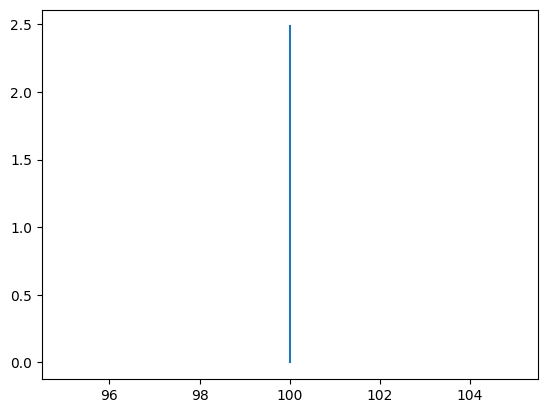

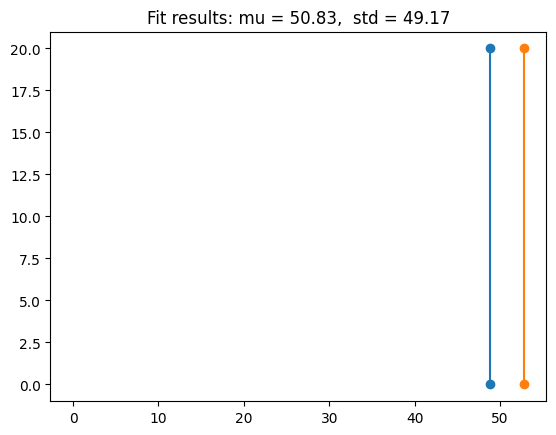

NeLow, NeHigh:48.87283661944587,52.792764588525976


(48.87283661944587, 52.792764588525976, 50.83280060398592)

In [1]:
#plot all estimated numbers of origins

# find a function that plots and finds maximum likelihood and the 95% confidence intervals
# calculating confidence interval by 
# 1. log ne hat and find maximum which should be the maximum of the graph as well
# average(origins) ?

import pandas as pd

def NeHat():
    '''
    This function plots the number of independent gene loci/origins (L) against population size (N). It also tells us NeHat (the mean), and the 95% confidence intervals.
    Do we just do the confidence intervals per N? 
    
    Arguments:
        csv_file_path: filepath of the results.csv used to manually record down the number of origins per simulation
        
    Returns:
        NeLow: lower point of 95% confidence intervals of NeHat being correct
        NeHigh: higher point of 95% confidence intervals of NeHat being correct
        NeHat: NeHat (at ln(Lmax))

    ''' 
    #load modules
    import pandas as pd
    import numpy as np
    from scipy.stats import norm
    import matplotlib.pyplot as plt
    import scipy

    #load csv
    origins = pd.read_csv('simulations/results.csv')


    # log the heterozygosity (ln(L))
    origins["ln(L)"] = np.log(origins['origins'])
    
    # At max ln(L), is Ne Hat
    #Lmax = origins['origins'].max()
    #ln_Lmax = np.log(Lmax) 
    
    # at [ln(Lmax)-2], Nelow and NeHigh are the confidence intervals
    #confidence_cutoff = ln_Lmax -2 
    #NeLow =       ##how to find best fit line and intersection?

    
    # load input variables from a file
    data =origins[['N','ln(L)']].copy()

    #subset by N and then loop through each 
    size_100 = data[(data["N"] == 100)]
    size_1000 = data[(data["N"] == 1000)]
    size_10000 = data[(data["N"] == 10000)]
    print (size_100)                                            
    
    # Fit a normal distribution to the data:
    mean, std = norm.fit(size_100)
    NeHat = mean #NeHat is the mean

    # get confidence intervals
    ci = scipy.stats.norm.interval(0.95, loc=mean, scale=1) #gets Confidence interval with equal areas around the mean
    #print(ci)

    # Plot 
    plt.plot(size_100['N'], size_100['ln(L)'] )
    plt.show()

    # Plot the PDF.
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 1)
    p = norm.pdf(x, mean, std)
    plt.plot(x, p, 'k', linewidth=2)
    title = "Fit results: mu = %.2f,  std = %.2f" % (mean, std)
    # confidence interval left line
    one_x12, one_y12 = [ci[0],ci[0]], [0, 20]
    # confidence interval right line
    two_x12, two_y12 = [ci[1],ci[1]], [0, 20]
    plt.plot(one_x12, one_y12, two_x12, two_y12, marker = 'o')
    plt.title(title)

    plt.show()

    NeLow = ci[0]
    NeHigh = ci[1]
    print ('NeLow, NeHigh:' + str(NeLow) + "," + str(NeHigh))

    # plot to look at confidence intervals, NeHat
    #Lmax = max (df['Heterozygosity'])
    #ln_Lmax = np.log(Lmax) 
    #plt.plot('cycle','Heterozygosity', data = df)
    #plt.axhline(y =ln_Lmax, color='r', linestyle='-') #ln_Lmax
    #plt.axhline(y=confidence_cutoff, color='r', linestyle='-') #confidence interval cutoff
    #plt.show()


    return NeLow, NeHigh, NeHat

NeHat()

In [2]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt


# Generate some data for this demonstration.
data = norm.rvs(10.0, 2.5, size=500)
print (data)

[11.00092592  2.14998292  5.79800191  9.22400636 14.08571814 11.82511286
  8.93805652 10.68069515 12.59456115  9.88192497  6.89578491  7.99532625
 12.38537701  3.861292   10.67604592  4.91965489  7.1797974  12.18414782
  8.20236657 12.33804328  9.53592512  9.07666574  7.1933953  13.69463353
  8.99374888 13.56348029 10.68729446 14.80866521  7.38682616  9.61114514
  7.66803721 10.53489933  7.71240974 11.3769187  11.85457079  7.90374934
  9.70117534  7.88400612  6.64912581 12.13676947 10.53854275 10.56748451
 15.40317838  9.8786316  10.84140631  9.81335598  8.25795827  9.91259042
 14.84272551  9.90618908  9.9837208   9.2831014  12.98673599 10.52597071
  9.88323204  9.56044209 11.74961247  7.12134455  9.42430012  8.60167629
  9.61907966  8.13076302  5.58049694 10.85710011  9.18018701  4.26137783
  9.68145043  5.48125715  9.83585115 11.95413026 10.38992979  9.95498565
 10.98504659  9.03207287 12.92741752 12.11105525  9.14949373  9.05674584
 14.23787417  8.08324139  9.81380824 10.10650981 11